In [ ]:
import QuantLib as ql
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
n=500000

## Parameters Preparation

### Get v0, theta, kappa, sigma, rho


In [ ]:
# Read the parquet file
def expend(data,n=n):
    # Get unique values from each column
    unique_values = {col: data[col].unique() for col in data.columns}

    # Create all possible combinations of the unique values
    combinations = list(itertools.product(*unique_values.values()))

    # Convert combinations into a DataFrame
    expanded_data = pd.DataFrame(combinations, columns=data.columns)

    # Shuffle the data to make it random and select exactly 500,000 rows
    if len(expanded_data) > n:
        expanded_data = expanded_data.sample(n=n, random_state=42)
    else:
        print(f"Warning: The number of unique combinations ({len(expanded_data)}) is less than 500,000.")

    # Save the expanded dataset
    return expanded_data

Heston_calibrated_parameters = expend(pd.read_parquet('Heston_calibrated_parameters.pq'))
Heston_calibrated_parameters

,v0,theta,kappa,sigma,rho
19993803,0.180665,0.006089,0.873200,6.004868e-06,0.016572
6072444,0.245998,0.327139,0.850837,4.540043e-06,0.014183
36645932,0.183330,0.319745,0.831421,3.585045e-05,0.037327
46773470,0.173578,0.916642,0.346984,6.461707e-06,0.014458
37237920,0.183330,2.000000,0.054130,1.000000e-10,0.011347
...,...,...,...,...,...
50418170,0.187798,0.967624,0.866577,1.928305e-05,0.017916
27738608,0.230737,1.999906,0.391601,4.829867e-06,0.020518
18237313,0.160133,1.999641,0.837704,1.928305e-05,0.017913
53179272,0.176812,1.998691,0.892851,4.829867e-06,0.030243


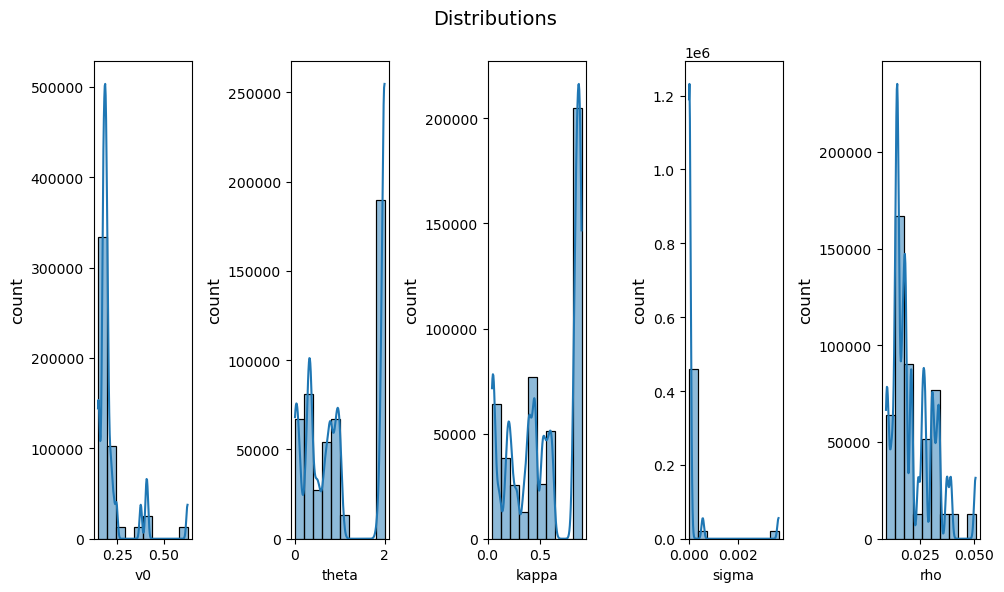

In [33]:
name = ['v0', 'theta', 'kappa', 'sigma', 'rho']

fig, axs = plt.subplots(1, 5, figsize=(10,6))


for i, param in enumerate(name):
    # 使用histplot可绘制柱状图+密度曲线,kde=True表示叠加核密度估计曲线
    sns.histplot(data=Heston_calibrated_parameters, x=param, kde=True, ax=axs[i], bins=10)
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('count', fontsize=12)
fig.suptitle('Distributions', fontsize=14)
plt.tight_layout()
plt.show()

convert them to arrays

In [34]:
# Create arrays from each column and assign them to variables with the same name as the column
for column in Heston_calibrated_parameters.columns:
    globals()[column] = Heston_calibrated_parameters[column].values
v0

array([0.18066456, 0.24599837, 0.18333009, ..., 0.16013273, 0.17681154,
       0.19482918])

### Get m,T,q,r

In [ ]:
data = pd.read_parquet('clean_data2023.pq')
data['moneyness'] = data['STRIKE']/data['UNDERLYING_LAST']
data = data[(data['C_IV']>0) & (data['P_IV']>0)]
data = data[(data['DTE']>=5)]
data = data[(data['moneyness']>=0.2) & (data['moneyness']<=5)]

params = data[['moneynes    s','DTE','rf','div']]
params.columns=['m','T','r','q']
params

,m,T,r,q
533,0.949813,5.00,0.042000,0.0171
544,0.964086,5.00,0.042000,0.0171
545,0.965384,5.00,0.042000,0.0171
546,0.966681,5.00,0.042000,0.0171
547,0.967979,5.00,0.042000,0.0171
...,...,...,...,...
1452982,1.049783,1904.04,0.045752,0.0156
1452983,1.073112,1904.04,0.045752,0.0156
1452984,1.096440,1904.04,0.045752,0.0156
1452985,1.119769,1904.04,0.045752,0.0156


In [ ]:
params = params.sample(n=n, replace=True, random_state=42)
for column in params.columns:
    globals()[column] = params[column].values
m

array([0.7297459 , 1.00700814, 0.81343651, ..., 0.92645004, 0.89123984,
       0.84118251])

## Now we can simulate price data

In [39]:
# Generate the price of a European call option using the Fourier Transform Method with the Heston model
def american_call_fourier(m, T, r, q, v0, theta, kappa, sigma, rho):
  '''
  m: Moneyness
  T: Time to maturity of the option
  r: Risk-free interest rate
  q: Dividend yield of the underlying asset
  v0: Initial volatility of the Heston mode
  theta: Mean reversion speed of the Heston model
  kappa: Mean reversion level of the Heston model
  sigma: Volatility of the Heston model
  rho: Correlation between the asset price and volatility processes
  '''

  # Parameters
  S0 = 1    # Current price of the underlying asset (scale)
  K = S0 * m    # Strike price of the option
  option_type = ql.Option.Call #Define call option???

  # Set up the option
  today = ql.Date.todaysDate()
  # expiry_date = today + ql.Period(T, ql.Days)
  expiry_date = today + ql.Period(f"{int(T*365)}d")
  option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call,K) ,ql.AmericanExercise(today,expiry_date)) #Plain Vanilla Option???

  # Set up the Heston model
  day_count=ql.Actual365Fixed()
  spot_handle = ql.QuoteHandle(ql.SimpleQuote(S0))
  flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
  dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))

  heston_process = ql.HestonProcess(flat_ts, dividend_yield, spot_handle, v0, kappa, theta, sigma, rho)
  heston_model = ql.HestonModel(heston_process)

  # Calculate the option price using the Heston model with the Fourier transform
  heston_engine = ql.FdHestonVanillaEngine(heston_model, 64)
  option.setPricingEngine(heston_engine)
  # print("The price of the European call option is:", option.NPV())

  # see if Feller Condition is fulfilled
  if 2*kappa*theta>(sigma**2):
    try:
      return option.NPV()
    except RuntimeError:
      return np.nan
  else:
    #print('Feller Condition is not fulfilled')
    return np.nan

# Test
american_call_fourier(1.05, 2, 0.05, 0.1, 0.05, 0.25, 1.0, 0.5, -0.5)

0.13339908260633274

In [40]:
def generate_samples_heston(N):

  prices = np.empty((N,)) # np.zeros((N,))
  for i in range(N):
    try:
      prices[i] = american_call_fourier(m[i], T[i], r[i], q[i], v0[i], theta[i], kappa[i], sigma[i], rho[i])
    except RuntimeError:
      prices[i] = np.nan

  df = pd.DataFrame({
        'moneyness':m,
        'Time to maturity':T,
        'interest rate':r,
        'divident yield':q,
        'initial vol':v0,
        'long term expected vol':theta,
        'vol revert rate':kappa,
        'vol of vol':sigma,
        'correlation of W and W':rho,
        'Call Option Price': prices
    })

  return df

In [43]:
heston_simulated = generate_samples_heston(n)

In [44]:
heston_simulated=heston_simulated.dropna()
heston_simulated

,moneyness,Time to maturity,interest rate,divident yield,initial vol,long term expected vol,vol revert rate,vol of vol,correlation of W and W,Call Option Price
1,1.007008,19.00,0.053200,0.0158,0.245998,0.327139,0.850837,4.540043e-06,0.014183,7.071305e-01
2,0.813437,127.96,0.048535,0.0170,0.183330,0.319745,0.831421,3.585045e-05,0.037327,7.347201e-01
3,0.916003,5.00,0.042900,0.0172,0.173578,0.916642,0.346984,6.461707e-06,0.014458,5.969919e-01
4,0.906428,36.00,0.043080,0.0166,0.183330,2.000000,0.054130,1.000000e-10,0.011347,7.946112e-01
5,0.631106,78.00,0.054360,0.0165,0.148507,1.999779,0.391601,6.461707e-06,0.030402,1.020158e+00
...,...,...,...,...,...,...,...,...,...,...
499994,0.438901,108.00,0.048920,0.0172,0.184927,2.000000,0.831421,2.675859e-06,0.014195,4.724808e+04
499995,0.831021,22.00,0.059500,0.0166,0.187798,0.967624,0.866577,1.928305e-05,0.017916,8.493386e-01
499996,0.977554,173.96,0.051595,0.0166,0.230737,1.999906,0.391601,4.829867e-06,0.020518,1.410206e+14
499997,0.926450,15.00,0.053700,0.0158,0.160133,1.999641,0.837704,1.928305e-05,0.017913,8.895243e-01


# Data Preprocessing

draw CDF to check extreme value

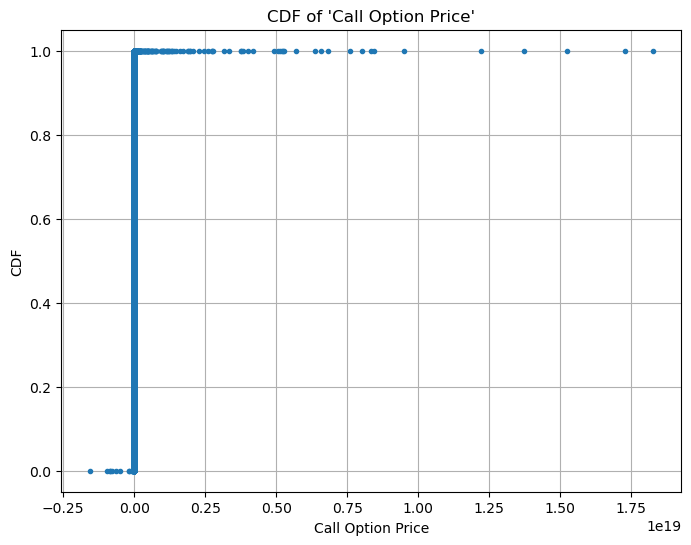

In [45]:
import matplotlib.pyplot as plt
sorted_data = np.sort(heston_simulated['Call Option Price'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.title("CDF of 'Call Option Price'")
plt.xlabel("Call Option Price")
plt.ylabel("CDF")
plt.grid()
plt.show()

In [72]:
heston_simulated=pd.read_parquet('heston_simulated_price.pq')

In [73]:
# 用IQR去掉极值
Q1 = heston_simulated['Call Option Price'].quantile(0.05)
Q3 = heston_simulated['Call Option Price'].quantile(0.95)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

heston_simulated = heston_simulated[(heston_simulated['Call Option Price'] >= lower_bound) &
                                    (heston_simulated['Call Option Price'] <= upper_bound)]
heston_simulated

,moneyness,Time to maturity,interest rate,divident yield,initial vol,long term expected vol,vol revert rate,vol of vol,correlation of W and W,Call Option Price
1,1.007008,19.00,0.053200,0.0158,0.245998,0.327139,0.850837,4.540043e-06,0.014183,0.707130
2,0.813437,127.96,0.048535,0.0170,0.183330,0.319745,0.831421,3.585045e-05,0.037327,0.734720
3,0.916003,5.00,0.042900,0.0172,0.173578,0.916642,0.346984,6.461707e-06,0.014458,0.596992
4,0.906428,36.00,0.043080,0.0166,0.183330,2.000000,0.054130,1.000000e-10,0.011347,0.794611
5,0.631106,78.00,0.054360,0.0165,0.148507,1.999779,0.391601,6.461707e-06,0.030402,1.020158
...,...,...,...,...,...,...,...,...,...,...
499989,1.034740,15.96,0.048000,0.0166,0.192691,0.696114,0.557240,2.675859e-06,0.014195,0.780859
499990,0.982338,9.00,0.055300,0.0156,0.214613,1.999863,0.831421,6.461707e-06,0.026009,0.878900
499995,0.831021,22.00,0.059500,0.0166,0.187798,0.967624,0.866577,1.928305e-05,0.017916,0.849339
499997,0.926450,15.00,0.053700,0.0158,0.160133,1.999641,0.837704,1.928305e-05,0.017913,0.889524


In [65]:
heston_simulated=heston_simulated[heston_simulated['Call Option Price']>0]
heston_simulated

,moneyness,Time to maturity,interest rate,divident yield,initial vol,long term expected vol,vol revert rate,vol of vol,correlation of W and W,Call Option Price
1,1.007008,19.00,0.053200,0.0158,0.245998,0.327139,0.850837,4.540043e-06,0.014183,0.707130
2,0.813437,127.96,0.048535,0.0170,0.183330,0.319745,0.831421,3.585045e-05,0.037327,0.734720
3,0.916003,5.00,0.042900,0.0172,0.173578,0.916642,0.346984,6.461707e-06,0.014458,0.596992
4,0.906428,36.00,0.043080,0.0166,0.183330,2.000000,0.054130,1.000000e-10,0.011347,0.794611
5,0.631106,78.00,0.054360,0.0165,0.148507,1.999779,0.391601,6.461707e-06,0.030402,1.020158
...,...,...,...,...,...,...,...,...,...,...
499989,1.034740,15.96,0.048000,0.0166,0.192691,0.696114,0.557240,2.675859e-06,0.014195,0.780859
499990,0.982338,9.00,0.055300,0.0156,0.214613,1.999863,0.831421,6.461707e-06,0.026009,0.878900
499995,0.831021,22.00,0.059500,0.0166,0.187798,0.967624,0.866577,1.928305e-05,0.017916,0.849339
499997,0.926450,15.00,0.053700,0.0158,0.160133,1.999641,0.837704,1.928305e-05,0.017913,0.889524


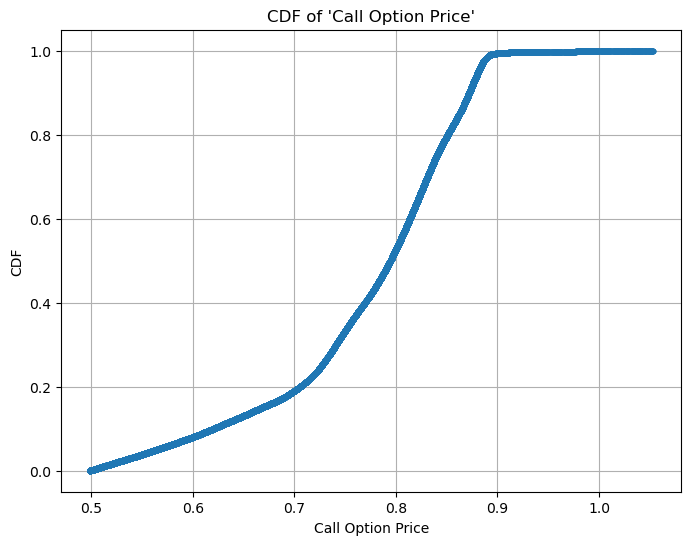

In [64]:
import matplotlib.pyplot as plt
sorted_data = np.sort(heston_simulated['Call Option Price'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.title("CDF of 'Call Option Price'")
plt.xlabel("Call Option Price")
plt.ylabel("CDF")
plt.grid()
plt.show()

In [66]:
heston_simulated[heston_simulated['Call Option Price']>heston_simulated['moneyness']].describe()

,moneyness,Time to maturity,interest rate,divident yield,initial vol,long term expected vol,vol revert rate,vol of vol,correlation of W and W,Call Option Price
count,52526.000000,52526.000000,52526.000000,52526.000000,52526.000000,52526.000000,52526.000000,5.252600e+04,52526.000000,52526.000000
mean,0.659739,49.459947,0.051436,0.016293,0.212449,1.224569,0.578011,1.799024e-04,0.021248,0.824236
std,0.159555,40.175218,0.004596,0.000661,0.089001,0.717954,0.287239,7.061075e-04,0.009422,0.062677
min,0.201556,5.000000,0.033600,0.015300,0.147201,0.004207,0.041907,1.000000e-10,0.009006,0.509333
25%,0.555385,20.960000,0.047400,0.015600,0.173578,0.658236,0.387324,4.540043e-06,0.014195,0.793402
50%,0.705027,35.000000,0.053120,0.016500,0.187384,0.991464,0.578677,1.265080e-05,0.017916,0.833308
75%,0.786184,67.000000,0.055265,0.017000,0.199566,1.999707,0.859380,2.562857e-05,0.027184,0.867148
max,1.037088,175.040000,0.060200,0.017200,0.625159,2.000000,0.892851,3.632535e-03,0.050611,1.053313


In [67]:
# save to parquet
heston_simulated.to_parquet('heston_simulated_price_preprocessed_0.25IQR.pq')